# Disentangled Causal Effect Variational Autoencoder

**Inputs:**
- data/heart_disease_cleaned.csv

**Outputs:**
- DCEVEA model
- data/fair_disease_dcevae.csv
- data/cf_disease_dcevea.csv

## Setup and imports

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
else:
  PROJECT_ROOT = '../'

sys.path.append(PROJECT_ROOT)

In [2]:
import torch
import pandas as pd
from src.config import Config
from src.data_loader import make_bucketed_loader
from src.model import DCEVAE
from src.train import train_dcevae
from src.test import test_dcevae
from src.utils import load_feature_mapping, setup_logger
from src.plots import train_val_loss_curve, disc_tc_loss_curve, distillation_loss_curve

### Args & Config

In [3]:
from argparse import Namespace
import datetime

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 4
BATCH_SIZE = 32
UC_DIM = 12
UD_DIM = 12
H_DIM = 5
ACT_FN = 'relu'
N_EPOCHS = 70
LEARNING_RATE = 0.01
CORR_RECON_ALPHA = 1
DESC_RECON_ALPHA = 1
PRED_ALPHA = 10
FAIR_BETA = 1
TC_BETA = 1
DISTILL_KL_ANN_N = 10
MAPPING = '../configs/uci_feature_mapping.json'
DATA = 'heart_disease_cleaned.csv'
EXP_NAME = datetime.datetime.now().strftime('%Y-%m-%d') + '_70'

args = Namespace(
    device=DEVICE,
    seed=SEED,
    batch_size=BATCH_SIZE,
    uc_dim=UC_DIM,
    ud_dim=UD_DIM,
    h_dim=H_DIM,
    act_fn=ACT_FN,
    n_epochs=N_EPOCHS,
    lr = LEARNING_RATE,
    distill_kl_ann = DISTILL_KL_ANN_N,
    corr_a = CORR_RECON_ALPHA,
    desc_a = DESC_RECON_ALPHA,
    pred_a = PRED_ALPHA,
    fair_b = FAIR_BETA,
    tc_b = TC_BETA,
    mapping = MAPPING,
    data = DATA,
    exp_name = EXP_NAME,
    root_dir = PROJECT_ROOT
)

## Training

In [ ]:
# Initialise logger
logger = setup_logger(PROJECT_ROOT + Config.LOG_DIR, args.exp_name)

#Load dataset
dataset = pd.read_csv(PROJECT_ROOT + Config.DATA_DIR + args.data)

#Load feature mapping
feature_mapping = load_feature_mapping(args.mapping)

# Bucketed data loaders for training , validation, and test
train_loader, val_loader, test_loader = make_bucketed_loader(dataset, feature_mapping)

# Feature metadata
ind_meta = feature_mapping['ind']
desc_meta = feature_mapping['desc']
corr_meta = feature_mapping['corr']
sens_meta = feature_mapping['sens']

model = DCEVAE(ind_meta, desc_meta, corr_meta, sens_meta, 
              args=args)

training_log, epoch_metrics_log = train_dcevae(
  model,
  train_loader,
  val_loader,
  logger,
  args
)

test_dcevae(model, test_loader, logger, args)


In [10]:
import os

training_metrics = pd.DataFrame(training_log)
results_path = f'{args.root_dir}{Config.RESULTS_DIR}{args.exp_name}'
os.makedirs(results_path, exist_ok=True)
training_metrics.to_csv(f'{results_path}/training_metrics.csv')

## Performance and fairness audit

### Training performance

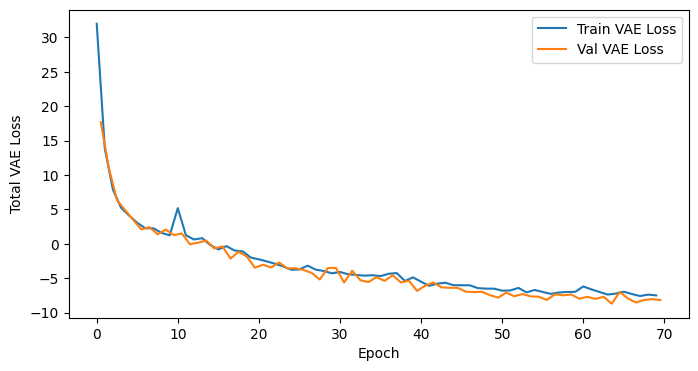

In [4]:
training_metrics = pd.read_csv(f'{args.root_dir}{Config.RESULTS_DIR}{args.exp_name}/training_metrics.csv')


train_val_loss_curve(training_metrics, args, show=True)

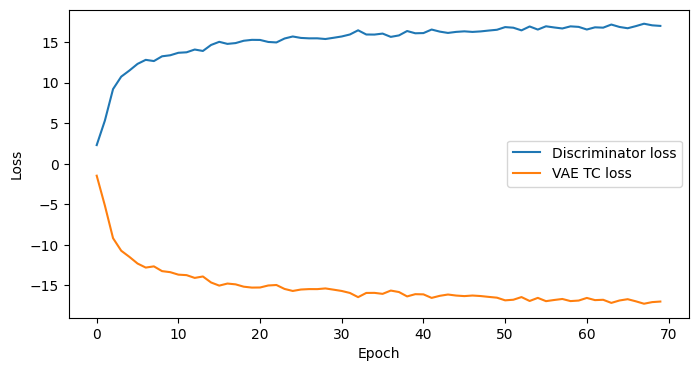

In [5]:
disc_tc_loss_curve(training_metrics, args, show=True)

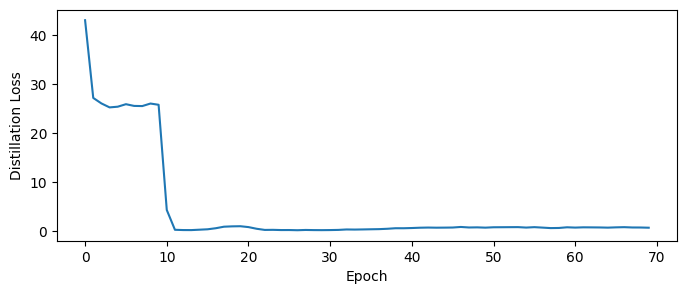

In [6]:
distillation_loss_curve(training_metrics, args, show=True)